In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.rough_scene import (
    ENVLIGHT_KEY,
    ROUGH_KEY,
    Scene,
    generate_rand_envlight,
    generate_rand_init_values,
    generate_rand_rough_tex,
    plot_rough_envlight,
    plot_rough_envlight2,
    reset_scene,
    reset_func,
    get_full_zeros_params,
    get_full_ones_params,
    run_opt_set_init,
    plot_opt_results,
)
from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

# Reference scenes rendering

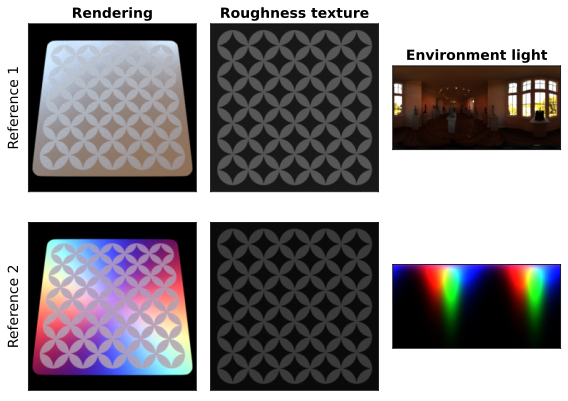

In [2]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_rough_ref = {k: params[k][ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: unidim_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: unidim_to_bm(params_envlight_ref[k])  for k in Scene}

refs = {k: {
    "img": image_ref_bm[k],
    "params_rough": params_rough_ref_bm[k],
    "params_envlight": params_envlight_ref_bm[k],
} for k in Scene}

def get_ref_params(scene_id):
    return {
        ROUGH_KEY: params_rough_ref[scene_id],
        ENVLIGHT_KEY: params_envlight_ref[scene_id],
    }

# Plot
plot_rough_envlight2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

# Scene 1 + Adam + relative L1 loss

In [3]:
nb_samples = 2
spp_primal = 32
spp_grad = 4

In [4]:
# get reference loss
scene = reset_scene(Scene.COND1)
image = mi.render(scene, mi.traverse(scene), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss = rel_l1_loss(image, image_ref[Scene.COND1])

In [5]:
init_values = [generate_rand_init_values(Scene.COND1, seed=i) for i in range(nb_samples)]
res_s1_adam_l1 = run_opt_set_init(image_ref[Scene.COND1], init_values, reset_func[Scene.COND1], n_iterations=200, optimizer_name="adam", lr=1e-2, loss_fn=rel_l1_loss, spp_primal=spp_primal, spp_grad=spp_grad)

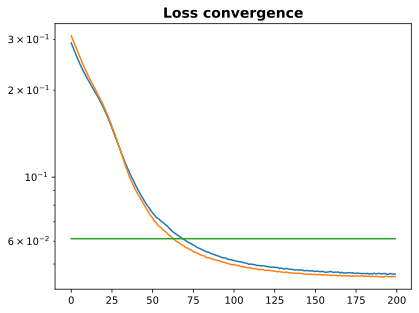

In [6]:
plot_losses(res_s1_adam_l1["losses"], baseline=ref_loss)

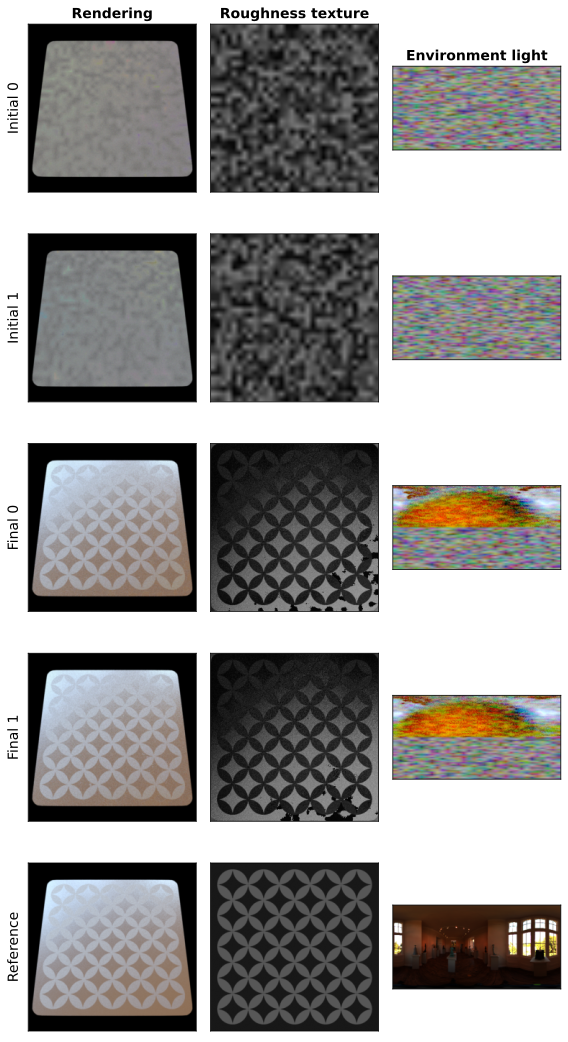

In [6]:
plot_opt_results(res_s1_adam_l1, refs[Scene.COND1], nb_results=nb_samples, size_factor=3)

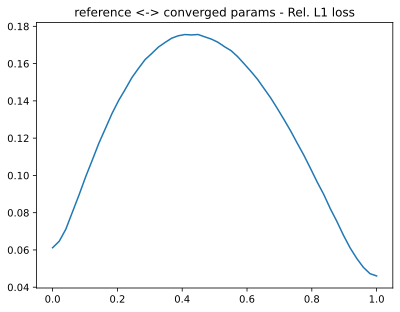

In [7]:
params_1 = get_ref_params(Scene.COND1)
params_2 = res_s1_adam_l1["params_end"][0]
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_func[Scene.COND1], title="reference <-> converged params - Rel. L1 loss", loss_fn=rel_l1_loss)

In [8]:
params_1 = get_ref_params(Scene.COND1)
params_2 = init_values[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_func[Scene.COND1], title="reference <-> init params - Rel. L1 loss", loss_fn=rel_l1_loss)

KeyboardInterrupt: 

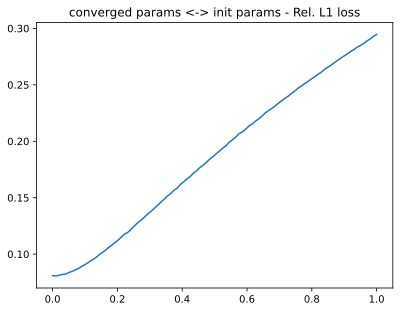

In [ ]:
params_1 = res_s1_adam_l1["params_end"][0]
params_2 = init_values[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_func[Scene.COND1], title="converged params <-> init params - Rel. L1 loss", loss_fn=rel_l1_loss)

# Scene 2 + Adam + relative L1 loss

In [ ]:
nb_samples = 2

In [ ]:
init_values = [generate_rand_init_values(Scene.COND2, seed=i) for i in range(nb_samples)]
res_s2_adam_l1 = run_opt_set_init(image_ref[Scene.COND2], init_values, reset_func[Scene.COND2], n_iterations=200, optimizer_name="adam", lr=2e-2, loss_fn=rel_l1_loss)

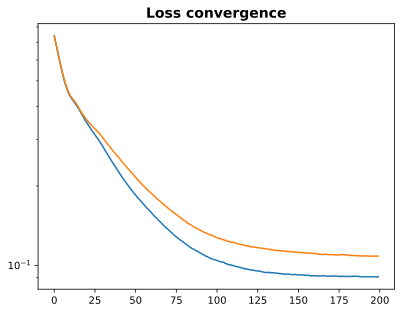

In [ ]:
plot_losses(res_s2_adam_l1["losses"])

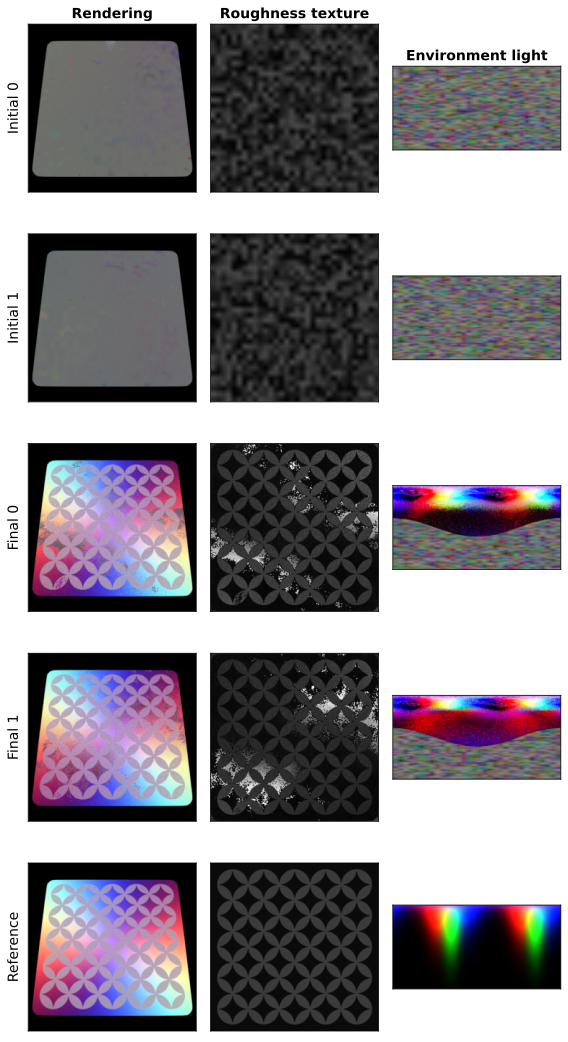

In [ ]:
plot_opt_results(res_s2_adam_l1, refs[Scene.COND2], nb_results=nb_samples, size_factor=3)

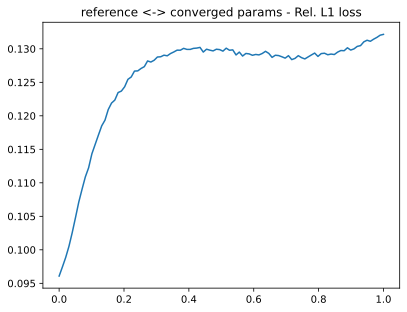

In [ ]:
params_1 = get_ref_params(Scene.COND2)
params_2 = res_s2_adam_l1["params_end"][0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> converged params - Rel. L1 loss", loss_fn=rel_l1_loss)

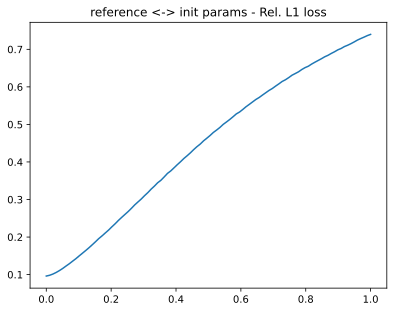

In [ ]:
params_1 = get_ref_params(Scene.COND2)
params_2 = init_values[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> init params - Rel. L1 loss", loss_fn=rel_l1_loss)

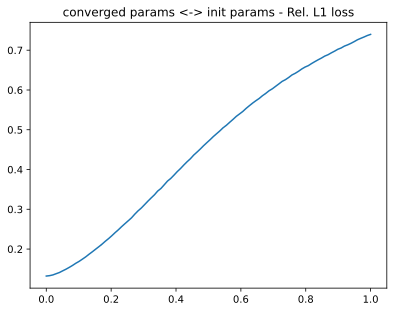

In [ ]:
params_1 = res_s2_adam_l1["params_end"][0]
params_2 = init_values[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="converged params <-> init params - Rel. L1 loss", loss_fn=rel_l1_loss)

# Sandbox (/!\ code may not run /!\ )

In [21]:
rand_rough = generate_rand_rough_tex(Scene.COND1, nb_opt_samples=1)[0]
envlight = mi.TensorXf(np.ones((128, 256, 3)))
res2 = run_opt_set_init(Scene.COND2, [(rand_rough, envlight)], n_iterations=200, optimizer_name="adam", lr=2e-2, loss_fn=rel_l1_loss)

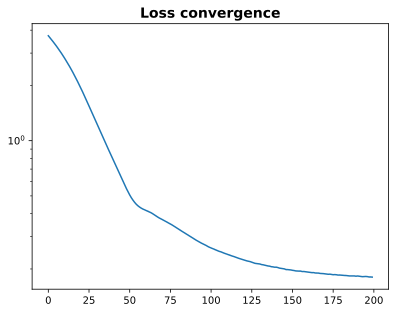

In [22]:
plot_losses(res2["losses"])

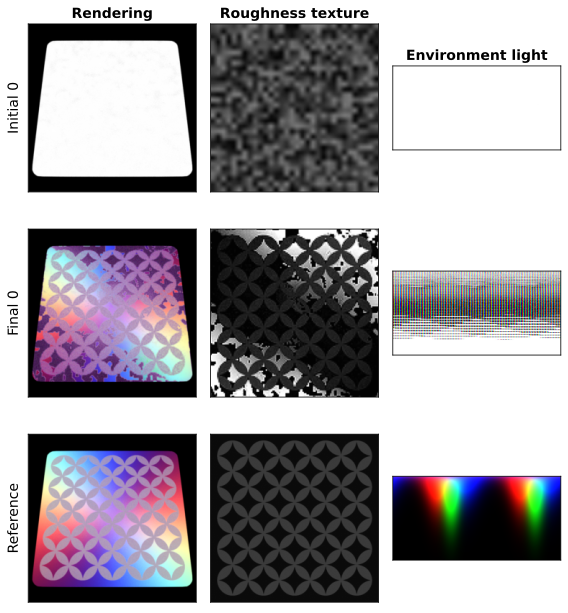

In [23]:
plot_opt_results(res2, Scene.COND2, nb_results=1, size_factor=3)

In [24]:
rand_rough = generate_rand_rough_tex(Scene.COND1, nb_opt_samples=1)[0]
envlight = mi.TensorXf(np.zeros((128, 256, 3)))
res2 = run_opt_set_init(Scene.COND2, [(rand_rough, envlight)], n_iterations=200, optimizer_name="adam", lr=2e-2, loss_fn=rel_l1_loss)

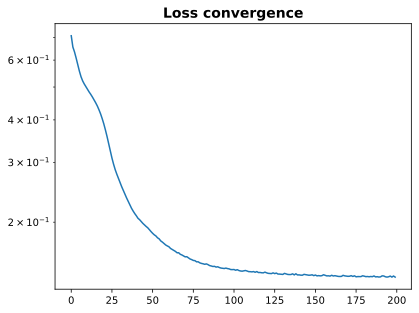

In [25]:
plot_losses(res2["losses"])

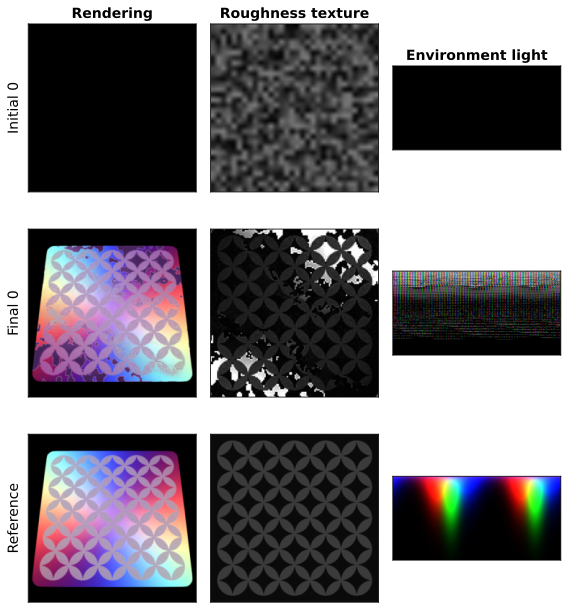

In [26]:
plot_opt_results(res2, Scene.COND2, nb_results=1, size_factor=3)